In [1]:
from scipy.stats import zscore
import seaborn as sns
import pickle
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.base import TransformerMixin, BaseEstimator

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [3]:
oa = pd.read_csv('..\\data\\temp\\oa.csv')

In [4]:
numerical_loggable_column_names = [
 'APPROXIMATE_DRIVING_ROUTE_MILEAGE',
 'PALLETIZED_LINEAR_FEET',
 'SECONDS_BETWEEN_ORDER_AND_DEADLINE',
 'LOAD_BAR_COUNT'
]
numerical_geo_column_names = [
'X_COORD', 
'Y_COORD', 
'X_COORD_DEST',
'Y_COORD_DEST'
]

bool_column_names = [
 'FD_ENABLED',
 'EXCLUSIVE_USE_REQUESTED',
 'HAZARDOUS',
 'REEFER_ALLOWED',
 'STRAIGHT_TRUCK_ALLOWED',
 'LOAD_TO_RIDE_REQUESTED',
]
categorical_column_names = [
 'DELIVERY_TIME_CONSTRAINT',
 #'TRANSPORT_MODE',
] 

# any boolean columns with nulls will be treated as a categorical column, since the null is a 3rd "category"
for bool_column_name in bool_column_names:
    if oa[bool_column_name].isnull().mean() != 0:
        categorical_column_names.append(bool_column_name)
        bool_column_names.remove(bool_column_name)

#['TRANSPORT_MODE','IS_POOLED_OR_GATE','ESTIMATED_COST_AT_ORDER','RATE_USD','LOAD_DELIVERED_FROM_OFFER',]

In [5]:
temp_df = oa.copy()

In [6]:
print(temp_df.shape)
print(temp_df.drop_duplicates(subset=["ORDER_REFERENCE_NUMBERS"]).shape[0])

temp_df = temp_df[temp_df["TRANSPORT_MODE"].isin(["PTL"])]
temp_df = temp_df[temp_df["LOAD_DELIVERED_FROM_OFFER"]==True]
temp_df = temp_df.drop_duplicates(subset=["ORDER_REFERENCE_NUMBERS"])

print(temp_df.shape)
print(temp_df["IS_POOLED_OR_GATE"].mean())

(833022, 47)
187364
(100319, 47)
0.3775655658449546


In [7]:
MODEL_INPUT_DF_INPUT_COLUMN_NAMES = (
numerical_loggable_column_names +\
numerical_geo_column_names +\
bool_column_names +\
categorical_column_names
)

class DebugCorr(BaseEstimator, TransformerMixin):
    def transform(self, X):
        return X

    def fit(self, X, y, **fit_params):
        print(X.shape)
        print(X.shape)
        df = pd.DataFrame(X)
        df["is_pool"]=y
        print(df.corr("spearman")["is_pool"].abs().sort_values(ascending=False).head(10))
        return self
    
class DebugPCA(BaseEstimator, TransformerMixin):
    def transform(self, X):
        print(X.shape)
        
        return X

    def fit(self, X, y, **fit_params):
        print(X.shape)
        fig1, ax1 = plt.subplots()
        ax1.scatter(
            X[:,0], 
            X[:,1],
            alpha=0.5,
            s=10,
            c=y)
        return self

def num_to_str_for_categ(x):
    return pd.DataFrame(x).astype(str)
num_to_str_for_categ_transformer = FunctionTransformer(num_to_str_for_categ)

def recenter_boolean_at_zero(x):
    return (pd.DataFrame(x)*2)-1
recenter_boolean_at_zero_transformer = FunctionTransformer(recenter_boolean_at_zero)



bool_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(
        strategy="constant",
    )),
    ("recenter", recenter_boolean_at_zero_transformer)    ,
])

categorical_columns_pipeline = Pipeline([
    ("bool_to_str_for_categ", num_to_str_for_categ_transformer),
    ("imp", SimpleImputer(
        strategy="constant",
        fill_value="__NULL_PLACEHOLDER__"
    )),
    ("one-hot", OneHotEncoder(sparse=True,handle_unknown="ignore")),
])

numer_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(
        strategy="median"
        #strategy="constant", fill_value=0
    )),
    ("normal", StandardScaler()),
])


log1p_transformer = FunctionTransformer(np.log1p)
numer_lognorm_columns_pipeline = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("log1p", log1p_transformer),
    ("normal", StandardScaler()),
    ("imp2", SimpleImputer(strategy="constant",fill_value=0)),
])

ct0 = ColumnTransformer([
    ("boolean",bool_columns_pipeline,bool_column_names),
    ("categ",categorical_columns_pipeline,categorical_column_names),
    ("numer",numer_columns_pipeline,numerical_geo_column_names),
    ("numer_lognorm",numer_lognorm_columns_pipeline,numerical_loggable_column_names)
])


# **Predicting if Pooled or Not**

In [8]:
X = temp_df[MODEL_INPUT_DF_INPUT_COLUMN_NAMES]
y = temp_df["IS_POOLED_OR_GATE"]

X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y)

MODEL = LogisticRegression(max_iter=500,class_weight='balanced')

pool_model = Pipeline([
        ("features", ct0),
        #("debug_corr", DebugCorr()),
        ("pca",PCA(10)),
        #("debug_pca", DebugPCA()),
        ("model", MODEL)
])
seed_i = 1
np.random.seed(seed_i)
pool_model.fit(X_train, y_train)

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('boolean',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('recenter',
                                                                   FunctionTransformer(func=<function recenter_boolean_at_zero at 0x000001E0AE6C6048>))]),
                                                  ['EXCLUSIVE_USE_REQUESTED',
                                                   'HAZARDOUS',
                                                   'REEFER_ALLOWED',
                                                   'STRAIGHT_TRUCK_ALLOWED',
                                                   'LOAD_TO_RIDE_REQUESTED']),
                                                 ('categ',
                                                  Pipelin...
           

In [9]:
np.random.seed(seed_i)
print("Score:", pool_model.score(X_test, y_test))

Score: 0.6418660287081339


c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


In [10]:
print("Cross val score:", cross_val_score(pool_model, X_train, y_train, cv=4))

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))
c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_func

Cross val score: [0.64455077 0.64816587 0.65066454 0.64001276]


c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


(2.0, 0)

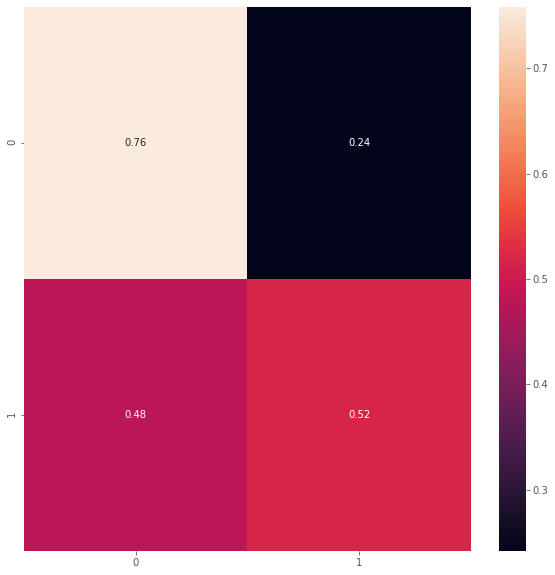

In [11]:
from sklearn.metrics import confusion_matrix

y_preds = pool_model.predict(X_test)

confusionMatrix = confusion_matrix(y_preds, y_test.values)
confusionMatrix = confusionMatrix/confusionMatrix.sum(axis=1,keepdims=1)

fig, ax = plt.subplots(figsize=(10,10)) 

ax = sns.heatmap(confusionMatrix, annot=True) #notation: "annot" not "annote"
y_lims = ax.get_ylim()

ax.set_ylim(sum(y_lims), 0)

# **Predicting Cost of Fulfill Pooled**

c:\users\benson\appdata\local\programs\python\python37\lib\site-packages\sklearn\preprocessing\_function_transformer.py:171: RuntimeWarning: invalid value encountered in log1p
  return func(X, **(kw_args if kw_args else {}))


(75239, 10)
(75239, 10)


Pipeline(steps=[('features',
                 ColumnTransformer(transformers=[('boolean',
                                                  Pipeline(steps=[('imp',
                                                                   SimpleImputer(strategy='constant')),
                                                                  ('recenter',
                                                                   FunctionTransformer(func=<function recenter_boolean_at_zero at 0x000001E0AE6C6048>))]),
                                                  ['EXCLUSIVE_USE_REQUESTED',
                                                   'HAZARDOUS',
                                                   'REEFER_ALLOWED',
                                                   'STRAIGHT_TRUCK_ALLOWED',
                                                   'LOAD_TO_RIDE_REQUESTED']),
                                                 ('categ',
                                                  Pipelin...
           

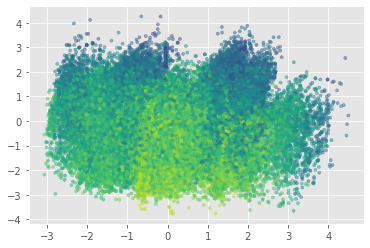

In [12]:
X = temp_df[MODEL_INPUT_DF_INPUT_COLUMN_NAMES]
y = temp_df["LOG(RATE_USD)"]
X_train, X_test, y_train, y_test = train_test_split(X,y)

MODEL = Ridge()

cost_model = Pipeline([
        ("features", ct0),
        #("debug_corr", DebugCorr()),
        ("pca",PCA(10)),
        ("debug_pca", DebugPCA()),
        ("model", MODEL)
])
seed_i = 1
np.random.seed(seed_i)
cost_model.fit(X_train, y_train)